In [1]:
import os
import json
import cv2
import h5py
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator #type: ignore
from tensorflow.keras.models import Sequential #type: ignore
from tensorflow.keras.layers import Flatten, Dense #type: ignore
from tensorflow.keras.preprocessing.image import load_img, img_to_array #type: ignore
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input #type: ignore
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [2]:
model = VGG16(include_top=False, input_shape=(224, 224, 3))
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
def extract_features(image_path):
    """Extract features using VGG16 model."""
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array)
    return features.flatten()

In [5]:
# Test the function
image_path = "input/images/0a0e8c15b-2.jpg" 
features = extract_features(image_path)
print("Extracted features shape:", features.shape)

# features

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
Extracted features shape: (25088,)


In [6]:
def load_found_pets_database(sample_size=1000):
    """Load a subset of images from a directory for testing."""
    directory = "input/images/"  # Replace with your directory
    all_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(('.jpg', '.jpeg', '.png'))]
    found_pets = all_files[:sample_size]  # Use only a sample for testing
    found_pet_features = [extract_features(pet_image) for pet_image in found_pets]
    return found_pets, found_pet_features

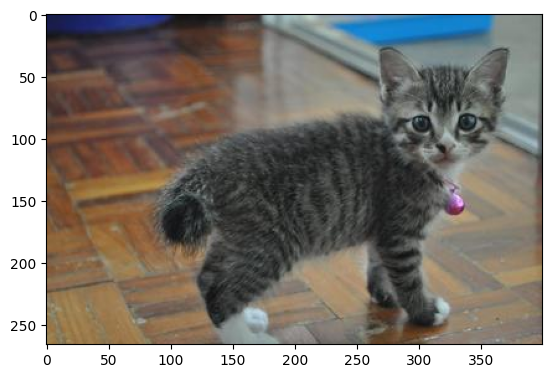

In [7]:
# Test using a sample of 100 images
directory = "input/images/"  # Replace with your directory
all_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(('.jpg', '.jpeg', '.png'))]
found_pets = all_files[:100]

idx = random.randint(0, len(found_pets) - 1)
image = plt.imread(found_pets[idx])
plt.imshow(image)
plt.show()

In [8]:
found_pets, found_pet_features = load_found_pets_database()
print("Number of found pets:", len(found_pets))
print("Feature shape for first pet:", found_pet_features[0].shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [9]:
def save_features_to_hdf5(found_pets, found_pet_features, output_file="found_pet_features.h5"):
    """Save features to an HDF5 file."""
    with h5py.File(output_file, "w") as f:
        # Create datasets for file paths and feature vectors
        f.create_dataset("file_paths", data=np.array(found_pets, dtype='S'))
        f.create_dataset("features", data=np.array(found_pet_features))

    print(f"Features saved to {output_file}")

In [10]:
save_features_to_hdf5(found_pets, found_pet_features)

Features saved to found_pet_features.h5


In [11]:
def load_features_from_hdf5(file="found_pet_features.h5"):
    """Load features from an HDF5 file."""
    with h5py.File(file, "r") as f:
        found_pets = list(f["file_paths"])
        found_pet_features = list(f["features"])

    # Decode bytes for file_paths and convert features to arrays
    found_pets = [pet.decode('utf-8') for pet in found_pets]  # Convert bytes to string
    found_pet_features = [np.array(features) for features in found_pet_features]

    return found_pets, found_pet_features

found_pets, found_pet_features = load_features_from_hdf5()

In [21]:
# Step 1: Simulate lost pet image (you can replace this with an actual uploaded image in the future)
lost_pet_image_path = "input/images/0a8e773aa-1.jpg"  

# Extract features from the lost pet image
lost_pet_features = extract_features(lost_pet_image_path)
print("Lost pet features shape:", lost_pet_features.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
Lost pet features shape: (25088,)


In [22]:
# Step 2: Calculate cosine similarity between the lost pet and found pets
similarities = [cosine_similarity([lost_pet_features], [features])[0][0] for features in found_pet_features]

similarities

[np.float32(0.14322168),
 np.float32(0.16470984),
 np.float32(0.16051425),
 np.float32(0.29038063),
 np.float32(0.17326173),
 np.float32(0.09531322),
 np.float32(0.1682603),
 np.float32(0.0920566),
 np.float32(0.18777114),
 np.float32(0.095862344),
 np.float32(0.12022786),
 np.float32(0.10195322),
 np.float32(0.13180283),
 np.float32(0.045219854),
 np.float32(0.09938814),
 np.float32(0.07868913),
 np.float32(0.15783866),
 np.float32(0.2047601),
 np.float32(0.13744582),
 np.float32(0.12423666),
 np.float32(0.13744582),
 np.float32(0.0822454),
 np.float32(0.0932361),
 np.float32(0.17651972),
 np.float32(0.056220558),
 np.float32(0.07482332),
 np.float32(0.10837927),
 np.float32(0.07964648),
 np.float32(0.09256524),
 np.float32(0.05768301),
 np.float32(0.06266287),
 np.float32(0.111242756),
 np.float32(0.090131685),
 np.float32(0.107067324),
 np.float32(0.08234734),
 np.float32(0.07759869),
 np.float32(0.1878314),
 np.float32(0.226449),
 np.float32(0.13782074),
 np.float32(0.13353641),
 n

In [23]:
# Step 3: Find the top 5 best matches (highest similarity scores)
top_n = 3  # Number of top matches to retrieve
sorted_indices = np.argsort(similarities)[::-1][:top_n]  # Get indices of top N similarities

# Retrieve the top matches
top_matches = [(found_pets[i], similarities[i]) for i in sorted_indices]

# Display the top matches
for rank, (pet_path, similarity) in enumerate(top_matches, start=1):
    print(f"Rank {rank}: {pet_path} (Similarity: {similarity:.2f})")


Rank 1: input/images/0a8e773aa-1.jpg (Similarity: 1.00)
Rank 2: input/images/0b01864e2-3.jpg (Similarity: 0.37)
Rank 3: input/images/087d71de3-2.jpg (Similarity: 0.31)


Top 3 Matches:


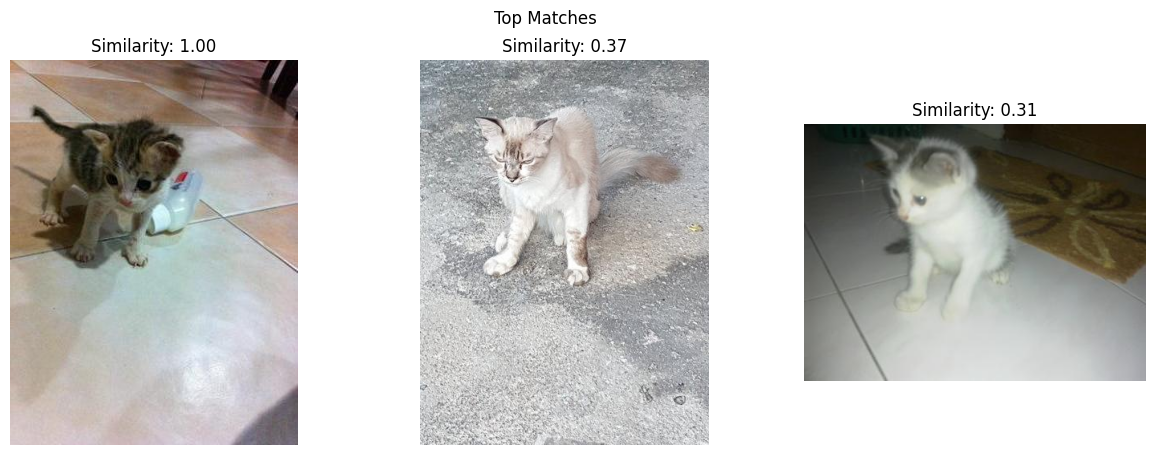

In [24]:
# Step 4: Display the results with images
if top_matches[0][1] > 0.1:  # Check if the top match's similarity is above the threshold
    print(f"Top {len(top_matches)} Matches:")
    
    # Create a subplot to display the top 5 images
    plt.figure(figsize=(15, 5))
    for i, (pet_path, similarity) in enumerate(top_matches, start=1):
        img = mpimg.imread(pet_path)  # Read the image
        plt.subplot(1, len(top_matches), i)  # Create subplot
        plt.imshow(img)  # Display image
        plt.axis("off")  # Hide axis
        plt.title(f"Similarity: {similarity:.2f}")  # Add similarity score as title
    
    plt.suptitle("Top Matches")  # Add a main title
    plt.show()
else:
    print(f"No good matches found. Best match: {top_matches[0][0]} (Similarity: {top_matches[0][1]:.2f})")